# Mini Project #2: MULTI-CONTROLLED $U$ GATE

Write a Qiskit function that takes two inputs: a positive integer $n$ and a matrix $U \in U(2)$ and outputs a quantum circuit on $n + 1$ qubits, possibly with further ancillas, that implements a multi-controlled $U$ gate, $C^nU$, that is
$$
C^n U \ket{x}_n \ket{y}_1 = 
\begin{cases}
\ket{x}_n U \ket{y}_1 \quad &\text{if } \, x = (1, 1, \dots, 1), \\
\ket{x}_n \ket{y}_1 \quad &\text{otherwise.}
\end{cases}
$$
The construction may only use arbitrary $1$-qubit gates ([$U$ gate](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.UGate)) and $CX$ gates. No classical bit and measurements allowed. 

Expectations:

• Documentation.

• Explanation of the construction (can use properly cited references).

• Working Qiskit code with benchmarking for low values of n.

• Analysis of the various complexities and resources used (at least for gate count, gate depth, and number of ancillas), in the “big-O” sense, as $n \to \infty$. 

# Solution:


# Case n=1:

We list some observations.

It is known that $Z = HXH$ and the CZ gate can be obtained from CNOT gate: $$CZ = (I \otimes H) CNOT (I\otimes H).$$

This can be seen from $$ CNOT = \ket{0} \bra{0} \otimes I + \ket{1} \bra{1} \otimes X ,$$ and multiplying this equation with $I\otimes H$ from both sides. 

The expression for $CZ$ is essentially a result of $Z= HXH$ and $H^2 = I$. 

Also known is the fact that $$CY = (I \otimes S) CNOT (I\otimes S^\dagger),$$ where $S$ is a phase gate with phase $\pi/2$ and $S^\dagger$ is its inverse. Similarly, this is a result of the identities $Y = S X S^\dagger$ and $S^\dagger S = I =S S^\dagger$.  

The controlled $U$ gate, in general, can be written as $$CU = \ket{0} \bra{0} \otimes I + \ket{1} \bra{1}\otimes U .$$ 

If $U$ is a $1$-qubit gate, then the controlled version of $U$, called $CU$, is the following 2-qubit gate:

$CU \ket{x}\ket{y} = \left\{ \begin{array}{ll} \ket{x} \ket{y}, 
& \textnormal{if } x = 0, \\ \ket{x} U \ket{y}, & \textnormal{if } x = 1. \end{array} \right.$

We know one decomposition of any unitary $U\in U(2)$ to have the form (up to a phase factor of $e^{-i\tfrac{\varphi+\lambda}{2}}$)
$$U(\theta, \varphi, \lambda) = \begin{bmatrix} \cos \left( \tfrac{\theta}{2} \right) & - e^{i \lambda} \sin \left( \tfrac{\theta}{2} \right) 
\\ e^{i \varphi} \sin \left( \tfrac{\theta}{2} \right) & e^{i (\varphi + \lambda)} \cos \left( \tfrac{\theta}{2} \right) \end{bmatrix}
= e^{i \frac{\lambda + \varphi}{2}} R_Z \left( \varphi + \tfrac{\pi}{2} \right) H R_Z (\theta) H R_Z \left( \lambda - \tfrac{\pi}{2} \right).$$
(see the problem session 1.)

This expression involves the Hadamard gates instead of the Pauli $X$-gate. But we know that $H= X R_Y \left(\tfrac{\pi}{2}\right)$ (see [this page](https://quantumcomputing.stackexchange.com/questions/21656/why-isnt-ry-pi-2-gate-equivalent-to-hadamard-gate)). We thus have 
$$U 
= e^{i \frac{\lambda + \varphi}{2}} R_Z \left( \varphi + \tfrac{\pi}{2} \right) X R_Y \left(\tfrac{\pi}{2}\right) R_Z (\theta) X R_Y \left(\tfrac{\pi}{2}\right) R_Z \left( \lambda - \tfrac{\pi}{2} \right).$$ 
However, we need a different decomposition of $U$ into separate rotation gates along $y, z$-axes. For this, we apply Nielsen and Chuang's Theorem 4.1 and Corollary 4.2. 

**Corollary 4.2 (Nielsen and Chuang):** Given $U\in U(2)$ as in the above, $$ U = e^{i\tfrac{-\varphi-\lambda}{2}}AXBXC \quad \text{with} \quad ABC = I,$$ where $$A= R_Z \left( \varphi \right) R_Y \left(\tfrac{\theta}{2}\right) , \quad  B=  R_Y \left(-\tfrac{\theta}{2}\right) R_Z \left(\tfrac{-\varphi-\lambda}{2}\right)  , 
\quad C =  R_Z \left(\tfrac{ \lambda -\varphi}{2} \right) .$$ 

Note: Not sure if this decomposition is unique. 

We can implement $C U$ as follows. 

In [10]:
pip install qiskit numpy

Note: you may need to restart the kernel to use updated packages.


In [11]:
from qiskit import quantum_info 
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator
from qiskit import transpile

import numpy as np

In [12]:
# Define Parameters 
Theta, Phi, Lam = Parameter(r"$\theta$"), Parameter(r"$\varphi$"), Parameter(r"$\lambda$")

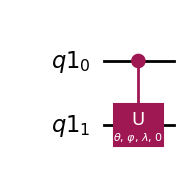

In [13]:
# Define controlled U gate:
from qiskit.circuit.library.standard_gates import UGate
quantum_register = QuantumRegister(2)
quantum_circuit = QuantumCircuit(quantum_register)
cu_gate = UGate(Theta, Phi, Lam).control(1)
quantum_circuit.append(cu_gate, quantum_register)
quantum_circuit.draw('mpl')

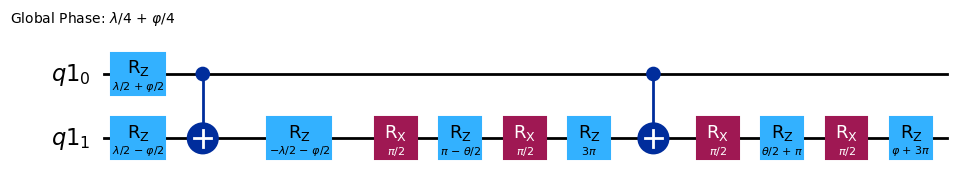

In [14]:
# We check the decomposition provided by Qiskit. 
decomposed_quantum_circuit = transpile(quantum_circuit, basis_gates = ['rx', 'ry', 'rz', 'cx'])
decomposed_quantum_circuit.draw('mpl')

We observe that this uses 11 phase gates and 2 control gates.

We try the above implementation provided by Corollary 4.2.

In [15]:
# Create the register and the circuit:
quantum_register = QuantumRegister(size=2, name="n=1 register")
quantum_circuit = QuantumCircuit(quantum_register)
# apply C
quantum_circuit.rz((Lam-Phi)/2,quantum_register[1])
# apply control gate
quantum_circuit.cx(quantum_register[0],quantum_register[1])
# apply B
quantum_circuit.rz((-Lam-Phi)/2,quantum_register[1])
quantum_circuit.ry((-Theta)/2,quantum_register[1])
# apply control gate
quantum_circuit.cx(quantum_register[0],quantum_register[1])
# apply A
quantum_circuit.ry((Theta)/2,quantum_register[1])
quantum_circuit.rz(Phi,quantum_register[1])
# apply phase gate to qubit zero
quantum_circuit.p((-Lam-Phi)/2, quantum_register[0])

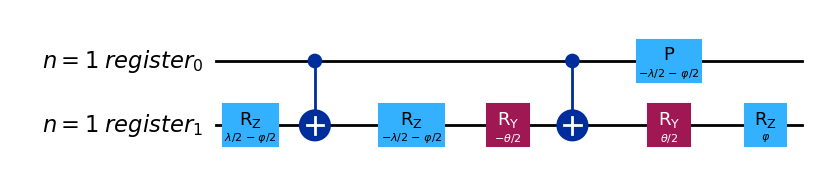

In [16]:
# Draw the above circuit.
quantum_circuit.draw(output='mpl')

We used $6$ phase gates and $2$ control gates. This matches the number of gates we will note later for general $n$, which is $30n-22$, and equals $8$ for $n=1$.

**Warning. The code below didn't allow to check the statevector, since Operator command has an issue when used with parameters.**

In [17]:
# Statevector(quantum_circuit).draw("Latex") gives 
# TypeError: ParameterExpression with unbound parameters (dict_keys([Parameter($\theta$)])) cannot be cast to a float.

**Explanation.**
We see that the above implements $C^1 U$, since $(I\otimes A) (CNOT) (I\otimes B)(CNOT) (I\otimes C) \ket{11} = AXBXC\ket{11} = U\ket{11}$, while for other states $\ket{xy}$, $(I\otimes A) (CNOT) (I\otimes B)(CNOT) (I\otimes C) \ket{xy} = ABC\ket{xy} = \ket{xy}$.

# Case $n = 2$:

Upon a literature search, the above method for $n=1$ can be generalized to $n\geq 2$ as in [1], Barenco et al, Lemma 7.9. However, that implimentation is further dependent on implimenting $C^{n-1} X$.

For bigger $n$, we will follow the construction in Figures 4.8 and 4.10 of Nielsen and Chuang's book, Quantum Computation and Quantum Information.  

Suppose that $V$ is a unitary operator such that $V^2 = U$. Such operators can be found from Qiskit as follows. 

**Warning. The below definitions give an error:**
TypeError: ParameterExpression with unbound parameters (dict_keys([Parameter($\theta$)])) cannot be cast to a float.

We still define the circuit below for the sake of mentioning it. For the case $n=2$, we will have to use the general case explained below for $n=5$.

In [18]:
# Define the square root of U using the power method. 
V = UGate(Theta, Phi, Lam).power(1/2)
# Define the dagger/inverse of V.
V_dag = V.power(-1)
# Define the controlled V gate.
cv_gate = V.control(1)
cv_dag = V_dag.control(1)

TypeError: ParameterExpression with unbound parameters (dict_keys([Parameter($\theta$)])) cannot be cast to a float.

In [ ]:
# Create the register and the circuit:
quantum_register = QuantumRegister(size=3, name="n=2 register")
quantum_circuit = QuantumCircuit(quantum_register)
# Add controlled V gate [1,2]
quantum_circuit.append(cv_gate, quantum_register[1:3])
# Add control gate [0,1]
quantum_circuit.cx(quantum_register[0],quantum_register[1])
# Add controlled V_dag gate [1,2]
quantum_circuit.append(cv_dag, quantum_register[1:3])
# Add control gate [0,1] again
quantum_circuit.cx(quantum_register[0],quantum_register[1])
# Add controlled V gate [0,2]
quantum_circuit.append(cv_gate, quantum_register[0:3])

In [ ]:
# Draw the circuit
quantum_circuit.draw(output='mpl')

### Case $n\geq 3$:


For $n\geq 3$, we follow Figure 4.10 of Nielsen and Chuang to implement $C^n U$. The figure only involves control gates, Toffoli gate $CCX$ and the $U$ gate itself. 

We will implement the Toffoli gate by using a construction from a question in problem session 1. 

One can also use the case $n=2$ above and take $U$ to be the $X$-gate to impliment the Toffoli gate. Indeed, Qiskit has a sqrtX gate ready to use. Thus, such a Toffoli gate implementation would require 4 gates if one uses the capabilities of Qiskit.

## Example. n=5: 
We need $5$ control qubits, 1 target qubit, and $4$ ancilla qubits in state $\ket{0}$. 


In [ ]:
quantum_register = QuantumRegister(5, name = "n=5 controls")
ancilla_register = AncillaRegister(4, name = "n=5 ancillas")
target_register = QuantumRegister(1, name = "n=5 target")
quantum_circuit = QuantumCircuit(quantum_register, ancilla_register, target_register, name="n=5 circuit")
# Add Toffoli gates.
quantum_circuit.ccx(quantum_register[0],quantum_register[1],ancilla_register[0])
quantum_circuit.ccx(quantum_register[2],ancilla_register[0],ancilla_register[1])
quantum_circuit.ccx(quantum_register[3],ancilla_register[1],ancilla_register[2])
quantum_circuit.ccx(quantum_register[4],ancilla_register[2],ancilla_register[3])
# Define a CU gate with one control. 
cu_gate = UGate(Theta, Phi, Lam).control(1)
# Add a CU gate between ancilla_register[3] and the target qubit. 
quantum_circuit.append(cu_gate, [ancilla_register[3], target_register[0]])
quantum_circuit.ccx(quantum_register[4],ancilla_register[2],ancilla_register[3])
quantum_circuit.ccx(quantum_register[3],ancilla_register[1],ancilla_register[2])
quantum_circuit.ccx(quantum_register[2],ancilla_register[0],ancilla_register[1])
quantum_circuit.ccx(quantum_register[0],quantum_register[1],ancilla_register[0])


In [ ]:
# Draw the circuit 
quantum_circuit.draw('mpl')

Therefore, in the case $n=5$, the implementation requires $8$ Toffoli gates and one $CU$ gate. From the above case for $n=1$,  we know that implementation of $CU$ gate requires $6$ phase gates and $2$ control gates. 

**Explanation.** 
This implements $C^5 U$, since if all the registry qubits are in state $\ket{1}$, then the ancilla qubits will be switched to $\ket{1}$ as well and $CU$ will apply. The second half of the circuit then switches the work qubits back to state $\ket{0}$. 

Otherwise, at least one registry qubit is in state $\ket{0}$, noticing that all registry qubits are connected to at least one ancilla qubit, the ancilla qubits will remain in their original state $\ket{0}$. Therefore, all other states $\ket{x_4 x_3 x_2 x_1 x_0}$ will remain unchanged.


We will now use the implementation of the Toffoli gate from the first problem session. 

In [ ]:
toffoli_register = QuantumRegister(3, "t")

toffoli_circuit = QuantumCircuit(toffoli_register)

toffoli_circuit.h(toffoli_register[2])
toffoli_circuit.cx(toffoli_register[1], toffoli_register[2])
toffoli_circuit.tdg(toffoli_register[2]) # tdg is the method for the inverse of T
toffoli_circuit.cx(toffoli_register[0], toffoli_register[2])
toffoli_circuit.t(toffoli_register[2])
toffoli_circuit.cx(toffoli_register[1], toffoli_register[2])
toffoli_circuit.tdg(toffoli_register[2])
toffoli_circuit.cx(toffoli_register[0], toffoli_register[2])
toffoli_circuit.t(toffoli_register[2])
toffoli_circuit.h(toffoli_register[2])
toffoli_circuit.cx(toffoli_register[0], toffoli_register[1])
toffoli_circuit.tdg(toffoli_register[1])
toffoli_circuit.cx(toffoli_register[0], toffoli_register[1])
toffoli_circuit.t(toffoli_register[0])
toffoli_circuit.t(toffoli_register[1])

#Draw the Toffoli circuit 
toffoli_circuit.draw(output="mpl")

Note that each Toffoli gate needs 2 Hadamard gates, 7 phase gates and 6 control gates. 

## Cost.

Therefore, having $8$ Toffoli gates and one $CU$ gate in our implementation of $C^5 U$, we need $8*15+8.1=128$ gates. 

For general $n$, we would need $15*2*(n-1)+8.1=30n-22$ gates, which is $O(n)$ gates. We also need $n-1$, so $O(n)$ ancilla qubits.

**Note. We can also define the $C^5 U$ gate from Qiskit.** 

In [ ]:
cu_5_gate = UGate(Theta, Phi, Lam).control(4)
qr = QuantumRegister(5)
qc = QuantumCircuit(qr)
qc.append(cu_5_gate, qr)
qc.draw('mpl')

In [ ]:
# We check the decomposition provided by Qiskit. 
decomposed_qc = transpile(qc, basis_gates = ['rx', 'ry', 'rz', 'cx'])
decomposed_qc.draw('mpl')

In [ ]:
# We check the number of gates in the above circuit.
print(dict(decomposed_qc.count_ops()))

The above circuit contains $92$ control gates and $151$ phase gates, so 243 gates in total, whereas the construction proposed previously required $128$ such single qubit gates.

## Other implementations in the literature: 

The construction above for general $n$ had depth $2n$ with $n$ of them being ancilla qubits, and it used $30n-22$ gates.

We mention some work from the literature that implements a $C^n U$ gate without any ancillas. 

In [1], Corollary 7.6, Barenco et al. provided an implementation of $C^nU$ with $O(n^2)$ gates. 

In [2], Silva and Park introduced an implimentation on a circuit with $O(n)$ depth and $O(n^2)$ gates that involve $2^n$th roots of the U gate in addition to controlled phase gates $C^k R_x(\pi)$ for $k<n-1$.

More recently, in [4], Theorem 1, Zindorf and Bose proposed an implimentation of $C^n U$ for $n\geq 6$. This needs no ancillas, but 8 $R$ gates, $O(n)$ many CNOT, T and H gates, and it has depth $O(n)$. 

**References:**

**1.** [Barenco et al] A. Barenco, C. H. Bennett, R. Cleve, D. P. DiVincenzo, N. Margolus, P. Shor, T. Sleator, J. A. Smolin, and H. Weinfurter, Elementary gates for quantum computation. Phys. Rev. A 52, 3457 (1995).

**2.** [Nielsen Chuang] M. Nielsen and I. Chuang, Quantum Computing and Quantum Information, Cambridge University Press, 10th anniversary edition.

**3.** [Silva Park] A. J. da Silva and D. K. Park, Linear-depth quantum circuits for multiqubit controlled gates, Phys. Rev. A 106, 042602.  
doi:(https://doi.org/10.1103/PhysRevA.106.042602)

**4.** [Zindorf Bose] B. Zindorf and S. Bose, Efficient Implementation of Multi-Controlled Quantum Gates, [arXiv](https://arxiv.org/pdf/2404.02279)